# Building the dataset

We are going to build a dataset from the Rate My Professors website using only UNT's professors, ratings, and comments. 

Let's get started by importing the libraries and testing the url endpoint. 

In [ ]:
import requests
import json
import math
import pandas as pd

page = requests.get('https://www.ratemyprofessors.com/filter/professor/?&page=800&filter=teacherlastname_sort_s+asc&query=*%3A*&queryoption=TEACHER&queryBy=schoolId&sid=1252')

if (page.status_code == 200):
        print("Getting page: ", pageCount)
        data = page.json()
        if(data['remaining'] == 0):
            print('none')

Next, we will gather a list of all the professors.

In [ ]:
# Instantiate an empty list of professors
allProfessors = []

# keep a flag to track if there are any remaining pages and the starting page count
stillRemaining = True
pageCount=1

# while the stillRemaining flag is true, we will loop through and request each page of professors. 
while stillRemaining:
    page = requests.get('https://www.ratemyprofessors.com/filter/professor/?&page=' + str(pageCount) + '&filter=teacherlastname_sort_s+asc&query=*%3A*&queryoption=TEACHER&queryBy=schoolId&sid=1252')
    if (page.status_code == 200):
        print("Getting page: ", pageCount)
        print(str(data['remaining']))
        data = page.json()
        allProfessors += data['professors']
        pageCount+=1
        if (data['remaining'] == 0):
            stillRemaining = False
    else:
        print("something went wrong")

Now that we have a list of professors, let's save it to a file so that we don't have to run the above code over and over again. 

In [ ]:
all_prof_df = pd.json_normalize(allProfessors)
all_prof_df.to_csv('all-professors.csv', index=False)
all_prof_df.df.shape

Let's pull in the all of the professors from the csv file.

In [ ]:
newDf = pd.read_csv('all-professors.csv')

Now, we need to gather all of the ratings by each professor. This requires us to loop through each professor and each page of ratings. 

In [ ]:
# Instantiate an empty list of ratings
allRatings = []

# loop through the list of professors
for ix, row in newDf.iterrows():
    # if the professor has ratings then fetch the ratings
    if (row['tNumRatings'] > 0):
        print('Teacher: ' + str(ix))

        # keep a flag to track if there are any remaining pages and the starting page count
        stillRemaining = True
        pageCount=1

        # while the stillRemaining flag is true, we will loop through and request each page of ratings. 
        while stillRemaining:
            page = requests.get('https://www.ratemyprofessors.com/paginate/professors/ratings?tid='+ str(row['tid']) +'&filter=&page='+ str(pageCount))
            if (page.status_code == 200):
                print("Getting page: ", pageCount)
                print(str(data['remaining']))
                data = page.json()
                ratings = data['ratings']
                for i in ratings:
                    i['tid'] = row['tid']
                    i['professor'] = row['tFname'] + ' ' + row['tLname']
                allRatings += ratings
                pageCount+=1
                if (data['remaining'] == 0):
                    stillRemaining = False
            else:
                print("something went wrong")

We now have all the ratings for professors at UNT. Let's save this to a file to start the preprocessing. 

In [ ]:
ratings_df = pd.json_normalize(allRatings)
ratings_df.to_csv('all-ratings.csv', index=False)
print(ratings_df.shape)

new_ratings_df = ratings_df.replace(r'\n',' ', regex=True)
new_ratings_df.to_csv('all-ratings-new.csv', index=False)
print(new_ratings_df.shape)

#Pre-processing the data

## Importing the necessary libraries

In [1]:
# import the needed libraries
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Loading the dataset


In [5]:
# Read the Rate My Professor Ratings data set and create the dataframe df. 
df = pd.read_csv('all-ratings-new.csv', engine='python')

# Print out the number of columns and rows for the dataframe
print(df.shape)

(43436, 33)


## Exploring the dataset

First, let's look at a few of the records to get a feel for the data.

In [6]:
# The head method gets the first five records of the dataframe.
df.head(5)

,attendance,clarityColor,easyColor,helpColor,helpCount,id,notHelpCount,onlineClass,quality,rClarity,rClass,rComments,rDate,rEasy,rEasyString,rErrorMsg,rHelpful,rInterest,rOverall,rOverallString,rStatus,rTextBookUse,rTimestamp,rWouldTakeAgain,sId,takenForCredit,teacher,teacherGrade,teacherRatingTags,unUsefulGrouping,usefulGrouping,tid,professor
0,NaN,good,poor,good,0,2056,0,NaN,awesome,5,130,No Comments,11/29/99,1,1,NaN,5,NaN,5.0,5.0,1,NaN,9.440000e+11,NaN,1252,NaN,NaN,NaN,[],people,people,997,David Holdeman
1,NaN,good,average,good,0,2062,1,NaN,awesome,5,POLSCI,No Comments,11/30/99,2,2,NaN,5,NaN,5.0,5.0,1,NaN,9.440000e+11,NaN,1252,NaN,NaN,NaN,[],person,people,805336,Gloria Cox
2,NaN,good,poor,good,0,2064,0,NaN,awesome,5,PSYCH,No Comments,11/30/99,1,1,NaN,5,NaN,5.0,5.0,1,NaN,9.440000e+11,NaN,1252,NaN,NaN,NaN,[],people,people,1005,Charles Guarnaccia
3,NaN,good,poor,good,0,2071,0,NaN,awesome,5,LINGUISTIC,A wonderful teacher!,11/30/99,1,1,NaN,5,NaN,5.0,5.0,1,NaN,9.440000e+11,NaN,1252,NaN,NaN,NaN,[],people,people,1012,Timothy Montler
4,NaN,good,poor,good,0,2072,0,NaN,awesome,5,RTVF,No Comments,11/30/99,1,1,NaN,5,NaN,5.0,5.0,1,NaN,9.440000e+11,NaN,1252,NaN,NaN,NaN,[],people,people,1013,Donald Staples


The first five records of the dataframe show that there are several columns of null/NaN values. This is due to no information entered by a student. This may indicate that some of these columns may not be useful for our purposes.

Next, we need to find out more about the data set by using the df.info method.
<br> It is good practice to know: 
* what the columns are
* the column data types
* if there are any null values allowed in the columns
* how many rows of data there are

In [7]:
#print the information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43436 entries, 0 to 43435
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   attendance         21414 non-null  object 
 1   clarityColor       43436 non-null  object 
 2   easyColor          43436 non-null  object 
 3   helpColor          43436 non-null  object 
 4   helpCount          43436 non-null  int64  
 5   id                 43436 non-null  int64  
 6   notHelpCount       43436 non-null  int64  
 7   onlineClass        3936 non-null   object 
 8   quality            43436 non-null  object 
 9   rClarity           43436 non-null  int64  
 10  rClass             43436 non-null  object 
 11  rComments          43394 non-null  object 
 12  rDate              43436 non-null  object 
 13  rEasy              43436 non-null  int64  
 14  rEasyString        43436 non-null  int64  
 15  rErrorMsg          0 non-null      float64
 16  rHelpful           434

The info method tells us: 

* rErrorMsg and teacher are not useful because they do not contain any data
* less than half the records contain a value for teacherGrade or rWouldTakeAgain
* just over half of the records contain a value for takenForCredit, rInterest, and attendance 
* only 3936 records have a value for onlineClass

Thanks to the info method, we reliably drop:
* rErrorMsg
* teacher
* teacherGrade
* rWouldTakeAgain
* takenForCredit
* rInterest
* attendance
* onlineClass

In [8]:
# list of columns to drop
drop_columns = ['rErrorMsg', 'teacher', 'teacherGrade', 'rWouldTakeAgain', 'takenForCredit', 'rInterest', 'attendance', 'onlineClass']
# drop columns (axis=1) without having to reassign df (inplace=True)
df.drop(drop_columns, axis=1, inplace=True)

The columns with 'String' appended to the column name are the same values as their respective columns. e.g. rOverallString and rOverall 

We will go ahead and drop those columns as well. 

In [9]:
# list of columns to drop
drop_columns = ['rEasyString', 'rOverallString']
# drop columns (axis=1) without having to reassign df (inplace=True)
df.drop(drop_columns, axis=1, inplace=True)

## Visualizing the original data set

The describe method is a great way to get statistical data about the data set quickly. It may also help find trends which is a vital part of the EDA process.

In [10]:
df.describe()

,helpCount,id,notHelpCount,rClarity,rEasy,rHelpful,rOverall,rStatus,rTimestamp,sId,tid
count,43436.000000,4.343600e+04,43436.000000,43436.000000,43436.000000,43436.000000,43436.000000,43436.000000,4.343600e+04,43436.000000,4.343600e+04
mean,0.660098,2.368098e+07,0.371305,3.643475,2.985381,3.673727,3.658601,1.022424,1.405914e+12,1249.300511,1.299126e+06
std,2.293989,7.510216e+06,1.626601,1.486278,1.263178,1.511965,1.459845,0.210584,1.441743e+11,106.310215,7.279321e+05
min,0.000000,2.056000e+03,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.440000e+11,60.000000,9.970000e+02
25%,0.000000,1.819094e+07,0.000000,2.000000,2.000000,2.000000,2.500000,1.000000,1.300000e+12,1252.000000,6.922070e+05
50%,0.000000,2.449296e+07,0.000000,4.000000,3.000000,4.000000,4.000000,1.000000,1.430000e+12,1252.000000,1.272522e+06
75%,1.000000,2.982279e+07,0.000000,5.000000,4.000000,5.000000,5.000000,1.000000,1.520000e+12,1252.000000,1.918284e+06
max,226.000000,3.517235e+07,99.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.640000e+12,13948.000000,2.730453e+06


On average (mean) we see: 
* rOverall rating is 3.658601 
* rHelpful rating is 3.673727
* rEasy rating is 2.985381

Next, let's temporarily keep only the numerical columns to help us visualize the data a little better.

In [11]:
# list of columns to visualize
vis_columns = ['rClarity', 'rEasy', 'rHelpful', 'rOverall']
# dataframe with only the vis_columns
df2 = df[vis_columns]

### Histograms
Histograms are great when we would like to show the distribution of the data we are working with.


<function matplotlib.pyplot.show>

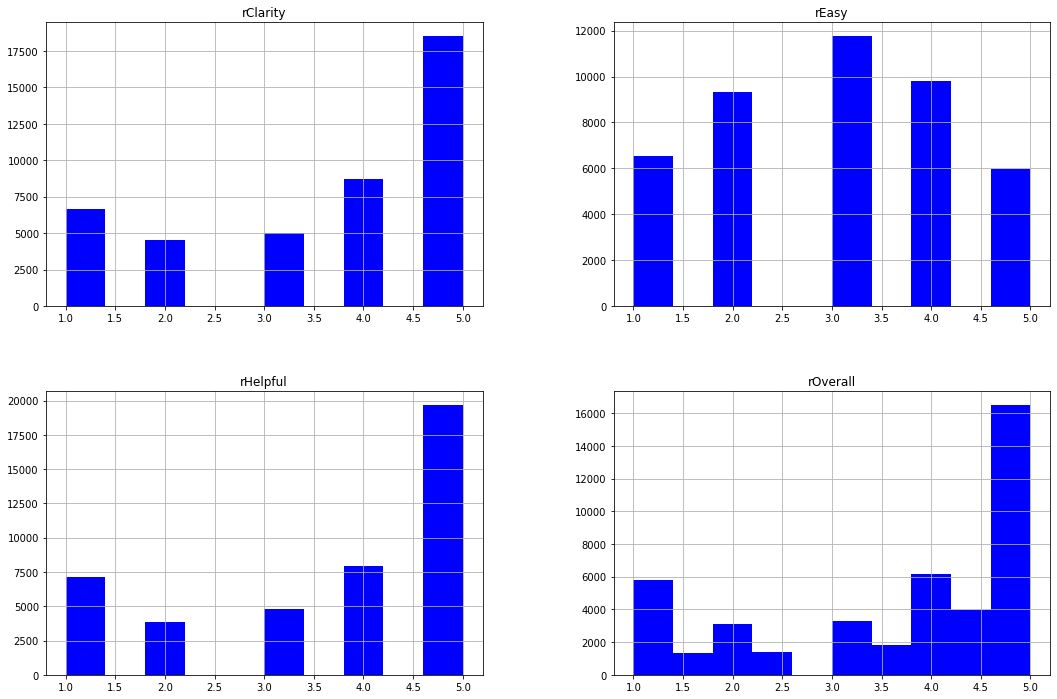

In [12]:
# We will create a histogram that is 18 inchees by 12 inches with the color blue. 
df2.hist(figsize=(18,12), color='blue')
plt.show

---------reserving this for a description about the charts above----------------

### Density Plots

* A Density Plot visualizes the distribution of data over a time period or a continuous interval. This chart is a variation of a Histogram but it smooths out the noise made by binning.

* Density Plots have a slight advantage over Histograms since they're better at determining the distribution shape and, as mentioned above, they are not affected by the number of bins used (each bar used in a typical histogram). As we saw above a Histogram with only 10 bins wouldn't produce a distinguishable enough shape of distribution as a 20-bin Histogram would. With Density Plots, this isn't an issue.

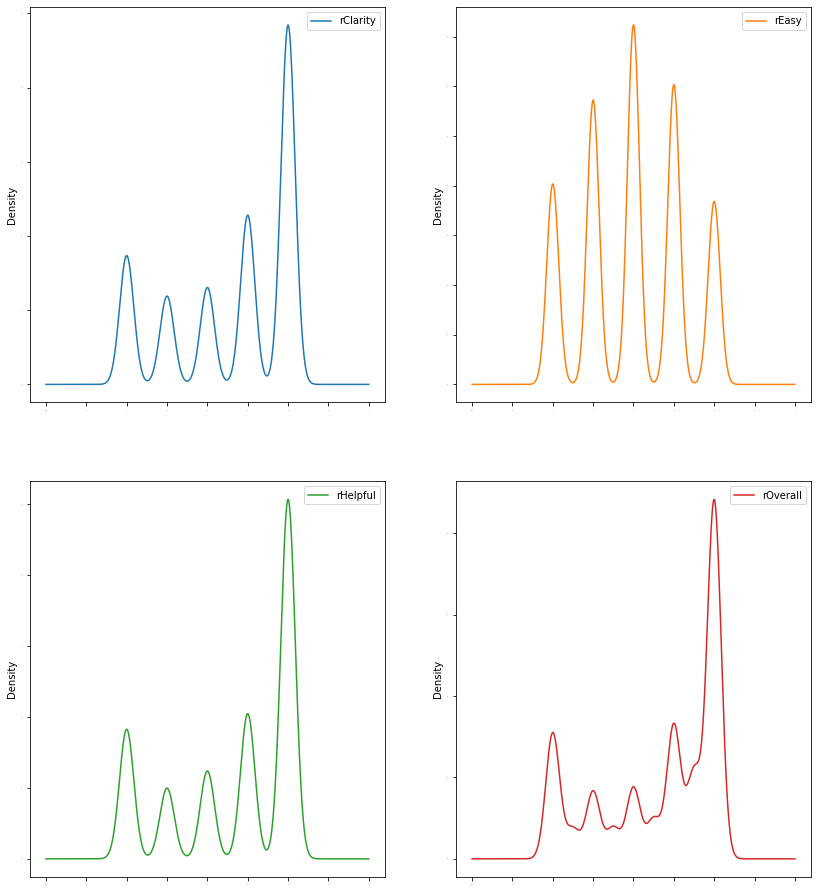

In [13]:
# create the density plot that subplots each feature in a 2 by 2 chart with a legend. The size of the overall plot will be 12 inches by 16 inches.

df2.plot(kind='density', subplots=True, layout=(2,2), sharex=False, legend=True, fontsize=1, figsize=(14,16))
plt.show()

# Processing the data 

Now that we've cleaned up the data, we need to perform our Sentiment Analysis. 

### Sentiment Analysis using Vader library in NLTK

In [23]:
# install the necessary library
!pip install language_tool_python

We will only utilize four columns for sentiment analysis: 
* id
* professor
* rOverall
* rComments

So, let's create another dataframe containing only the specific columns necessary

In [131]:
dfs = df[['id', 'professor', 'rOverall','rComments', 'rEasy']]

dfs = dfs[42400:43436] # if want to work on the entire dataset, comment this out

From the analysis done above, we can see that rComments has some null values. Let's double check that and then remove those rows.

In [132]:
if (dfs['rComments'].isnull().values.any()): 
    print('Number of missing comments:', dfs['rComments'].isnull().sum())
    dfs.dropna(inplace=True)
    print('Number of missing comments after dropping: ', dfs['rComments'].isnull().sum())

Next, we will import the nltk library and download the vader_lexicon. Then, we will instantiate the SentimentIntensityAnalyzer.

In [133]:
# downloading and setting up the sentiment analysis
 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Let's test the analyzer on the first comment to see what it returns. 

In [134]:
# testing sentiment analsis just on one comment

score = sid.polarity_scores(dfs['rComments'].iloc[0])
print('Sentiment score of comment: ', '"',dfs['rComments'].iloc[0],'"',
      ' is: \n compound: ', score['compound'], '\n negative: ', score['neg'], 
      '\n neutral: ', score['neu'], '\n positive: ', score['pos'] )

Sentiment score of comment:  " Professor Jennings was SO hard to contact. She never emailed me or my classmates back when we had questions. Whenever we had assignments, she never clearly stated what she wanted from us, and she was a REALLY tough grader. Do not take her if you have another option. Overall one of the worst professors I have ever had in my college experience. "  is: 
 compound:  -0.8836 
 negative:  0.168 
 neutral:  0.832 
 positive:  0.0


We can see that the polarity score returns the compound, negative, neutral, and positive scores for a given text.

Let's go ahead and run this against the entire dataset.

In [135]:
# performing sentiment analysis for each comment and saving the score in the dataframe

length = dfs.count()
sent_compound = []
sent_neg = []
sent_neu = []
sent_pos = []
#lang_quality = []
for i in range(length[1]):
  score = sid.polarity_scores(dfs['rComments'].iloc[i])
  sent_compound.append(score['compound'])
  sent_neg.append(score['neg'])
  sent_neu.append(score['neu'])
  sent_pos.append(score['pos'])
  #print(score['compound'])

  #l_q = lang_quality(df['rComments'].iloc[i])
  #matches = tool.check(df['rComments'].iloc[i])
  #num_error = len(matches)  #number of suggested corrections in the review
  #num_w = len(df['rComments'].iloc[i].split()) #number of words in the review
  #error_rate = num_error/num_w #language quality rate
  #lang_quality.append(error_rate)

dfs['sent_compound'] = sent_compound
dfs['sent_neg'] = sent_neg
dfs['sent_neu'] = sent_neu
dfs['sent_pos'] = sent_pos
#df['language_quality'] = lang_quality

Now that we've calculated the sentiment analysis of the entire dataset, let's perform some language quality calculations to gauge the quality of the comments.

### Language quality calculation

In [136]:
# laguage quality calculation
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [137]:
# improvised by me model of calculation of language quality (aka error rate) :)

# this cell quite some time to run (4h); be careful
length = dfs.count()

lang_quality = []
print('Calculating language quality........')
for i in range(length[1]):
  matches = tool.check(dfs['rComments'].iloc[i])
  num_error = len(matches)  #number of suggested corrections in the review
  num_w = len(dfs['rComments'].iloc[i].split()) #number of words in the review
  error_rate = num_error/num_w #language quality rate
  lang_quality.append(error_rate)
  print('STEP', i, ': \n', 'Error Rate: ', error_rate)

dfs['language_quality'] = lang_quality

Calculating language quality........
STEP 0 : 
 Error Rate:  0.0
STEP 1 : 
 Error Rate:  0.02127659574468085
STEP 2 : 
 Error Rate:  0.01639344262295082
STEP 3 : 
 Error Rate:  0.06779661016949153
STEP 4 : 
 Error Rate:  0.0
STEP 5 : 
 Error Rate:  0.016666666666666666
STEP 6 : 
 Error Rate:  0.0
STEP 7 : 
 Error Rate:  0.04838709677419355
STEP 8 : 
 Error Rate:  0.017543859649122806
STEP 9 : 
 Error Rate:  0.0
STEP 10 : 
 Error Rate:  0.05660377358490566
STEP 11 : 
 Error Rate:  0.029411764705882353
STEP 12 : 
 Error Rate:  0.015625
STEP 13 : 
 Error Rate:  0.03333333333333333
STEP 14 : 
 Error Rate:  0.017241379310344827
STEP 15 : 
 Error Rate:  0.0
STEP 16 : 
 Error Rate:  0.047619047619047616
STEP 17 : 
 Error Rate:  0.038461538461538464
STEP 18 : 
 Error Rate:  0.0
STEP 19 : 
 Error Rate:  0.047619047619047616
STEP 20 : 
 Error Rate:  0.018518518518518517
STEP 21 : 
 Error Rate:  0.01694915254237288
STEP 22 : 
 Error Rate:  0.037037037037037035
STEP 23 : 
 Error Rate:  0.0
STEP 24

Let's take a look at the data!

In [138]:
dfs.head()

,id,professor,rOverall,rComments,rEasy,sent_compound,sent_neg,sent_neu,sent_pos,language_quality
42400,34674265,Debbra Jennings,1.0,Professor Jennings was SO hard to contact. She...,5,-0.8836,0.168,0.832,0.000,0.000000
42401,34677522,Jennifer Judd,5.0,One of the best professors Ive had. Her assign...,3,0.9500,0.000,0.704,0.296,0.021277
42402,34676030,Vincent Lopes,5.0,"I struggle quite a bit with physics, E&amp;M w...",5,0.8022,0.054,0.796,0.149,0.016393
42403,34676812,Jessica Moore,4.0,Dr. Moore is great. I had her for Genetics thi...,3,-0.1386,0.101,0.806,0.093,0.067797
42404,34676916,Alexander Updegrove,5.0,2020-2021 has been a difficult year and some m...,3,0.8398,0.086,0.673,0.241,0.000000


We can now see that each record now has a language quality score. Let's build more on top of this by calculating text complexity measures for each comment. 

### Text Complexity Measures

In [139]:
# Text Complexity Measures

!pip install textstat

In [111]:
import textstat

In [140]:
# Readability: The Flesch Reading Ease formula -- the higher value -- the easier text
length = dfs.count()

flesch_reading_ease = []
print('Calculating The Flesch Reading Ease Index........')
for i in range(length[1]):
  text = dfs['rComments'].iloc[i]
  reading_ease = textstat.flesch_reading_ease(text)
  flesch_reading_ease.append(reading_ease)
  #print('STEP', i, ': \n', 'Reading ease: ', error_rate)

dfs['flesch_reading_ease'] = flesch_reading_ease
print('Complete.')

Calculating The Flesch Reading Ease Index........
Complete.


Let's take another look at the data to get a feel for what the flesch_reading_ease score is.

In [141]:
dfs.head()

,id,professor,rOverall,rComments,rEasy,sent_compound,sent_neg,sent_neu,sent_pos,language_quality,flesch_reading_ease
42400,34674265,Debbra Jennings,1.0,Professor Jennings was SO hard to contact. She...,5,-0.8836,0.168,0.832,0.000,0.000000,67.35
42401,34677522,Jennifer Judd,5.0,One of the best professors Ive had. Her assign...,3,0.9500,0.000,0.704,0.296,0.021277,67.96
42402,34676030,Vincent Lopes,5.0,"I struggle quite a bit with physics, E&amp;M w...",5,0.8022,0.054,0.796,0.149,0.016393,84.47
42403,34676812,Jessica Moore,4.0,Dr. Moore is great. I had her for Genetics thi...,3,-0.1386,0.101,0.806,0.093,0.067797,76.42
42404,34676916,Alexander Updegrove,5.0,2020-2021 has been a difficult year and some m...,3,0.8398,0.086,0.673,0.241,0.000000,80.31


Now that we have a text complexity measure, let's calculate the lexical diversity of the comment. 

### Lexical Diversity

In [114]:
# Lexical Diversity 

!pip install lexicalrichness

# ref: https://pypi.org/project/lexicalrichness/

In [115]:
from lexicalrichness import LexicalRichness

In [142]:
length = dfs.count()

lex_rich = []
ttr = []
herdan = []
fkg = []
print('Calculating Lexical Diversity (richness).......')
for i in range(length[1]):
  text = dfs['rComments'].iloc[i]
  lex = LexicalRichness(text) 
  ttr1 = lex.ttr
  #herdan1 = lex.Herdan #Herdan's lexical diversity measure. #issue with division on 0, removed for now, need to look into formula
  fkg1 = textstat.flesch_kincaid_grade(text) # the value is an equivalent to the school grade
  fkg.append(fkg1)
  lex_rich.append(lex)
  ttr.append(ttr1)
  #herdan.append(herdan1)
  #print('STEP', i, ': \n', 'Reading ease: ', error_rate)

dfs['flesch_reading_ease'] = flesch_reading_ease
dfs['lex_rich'] = lex_rich
dfs['ttr'] = ttr
#dfs['herdan'] = herdan
dfs['flesch_kincaid_grade'] = fkg
print('Complete.')

Calculating Lexical Diversity (richness).......
Complete.


Let's take a look at the dataset now. 

In [143]:
dfs.head()

,id,professor,rOverall,rComments,rEasy,sent_compound,sent_neg,sent_neu,sent_pos,language_quality,flesch_reading_ease,lex_rich,ttr,flesch_kincaid_grade
42400,34674265,Debbra Jennings,1.0,Professor Jennings was SO hard to contact. She...,5,-0.8836,0.168,0.832,0.000,0.000000,67.35,professor jennings was so hard to contact she ...,0.838710,6.9
42401,34677522,Jennifer Judd,5.0,One of the best professors Ive had. Her assign...,3,0.9500,0.000,0.704,0.296,0.021277,67.96,one of the best professors ive had her assignm...,0.826087,6.7
42402,34676030,Vincent Lopes,5.0,"I struggle quite a bit with physics, E&amp;M w...",5,0.8022,0.054,0.796,0.149,0.016393,84.47,i struggle quite a bit with physics e amp m wa...,0.861538,4.5
42403,34676812,Jessica Moore,4.0,Dr. Moore is great. I had her for Genetics thi...,3,-0.1386,0.101,0.806,0.093,0.067797,76.42,dr moore is great i had her for genetics this ...,0.859649,5.5
42404,34676916,Alexander Updegrove,5.0,2020-2021 has been a difficult year and some m...,3,0.8398,0.086,0.673,0.241,0.000000,80.31,has been a difficult year and some more diffic...,0.875000,6.1


We now have a ttr score and a flesch_kincaide_grade! Let's save this to a new csv file and explore the data a bit more. 

In [144]:
dfs.to_csv('all-ratings-computed.csv')

# Visualizing the processed data. 

### Box plot
A box plot is a very good plot to understand the spread, median, and outliers of data

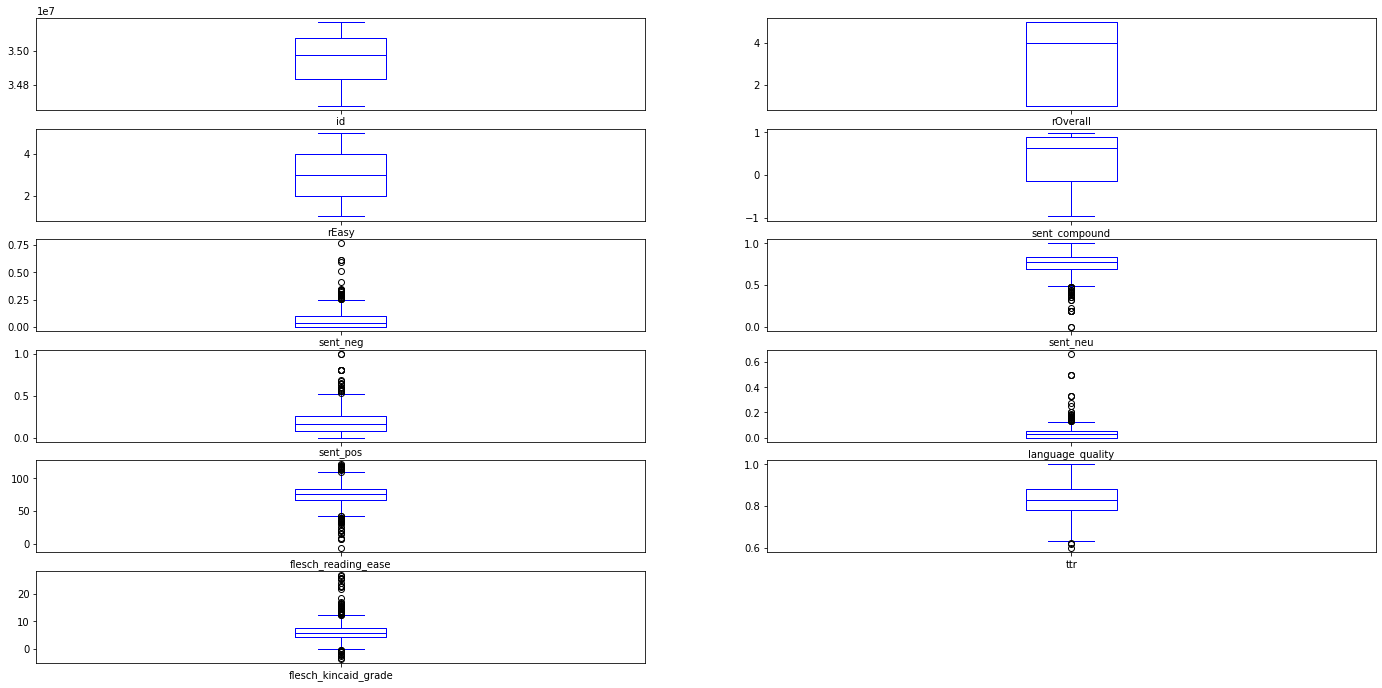

In [145]:
dfs.plot(kind='box', subplots=True, layout=(10,2), sharex=False, sharey=False, color = 'blue', figsize=(24,20))
plt.show()

### Scatter Matrix Plot

A scatter plot matrix is a grid (or matrix) of scatter plots. This type of graph is used to visualize bivariate relationships between different combinations of variables. Each scatter plot in the matrix visualizes the relationship between a pair of variables, allowing many relationships to be explored in one chart.

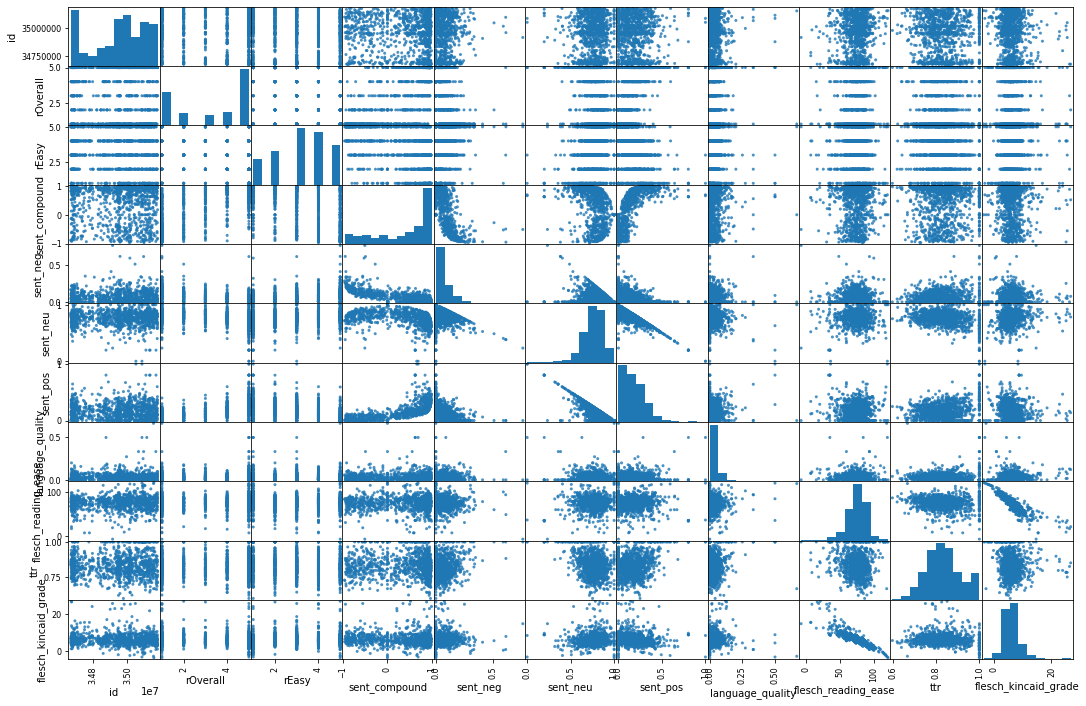

In [146]:
# create a scatter matrix plot

scatter_matrix (dfs, alpha=0.8, figsize=(18,12))
plt.show()

## KNN clustering

In [155]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import utils

In [164]:
X = dfs.drop(['rComments', 'lex_rich', 'professor','rOverall', 'id'], axis=1)
y = dfs['rOverall'].astype('int')

In [165]:
from sklearn.model_selection import train_test_split
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [166]:
#lab_enc = preprocessing.LabelEncoder()
#encoded = lab_enc.fit_transform(y)

In [167]:
neigh = KNeighborsClassifier(n_neighbors = 24)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=24)

In [160]:
X_test

,sent_compound,sent_neg,sent_neu,sent_pos,language_quality,flesch_reading_ease,ttr,flesch_kincaid_grade
43135,0.9223,0.034,0.734,0.232,0.017241,73.68,0.813559,6.6
42951,-0.1139,0.039,0.929,0.032,0.031746,86.20,0.806452,3.8
43252,-0.8674,0.161,0.794,0.045,0.014493,82.85,0.657143,5.1
43353,-0.1280,0.087,0.819,0.094,0.000000,83.66,0.771429,4.8
42675,0.8519,0.000,0.420,0.580,0.125000,88.74,1.000000,2.9
...,...,...,...,...,...,...,...,...
42888,-0.0168,0.144,0.728,0.128,0.034483,76.62,0.779661,5.5
42652,0.0000,0.000,1.000,0.000,0.000000,90.80,0.840909,4.1
42863,0.9328,0.063,0.694,0.243,0.043478,82.85,0.833333,5.1
42523,0.9152,0.000,0.748,0.252,0.020833,78.65,0.729167,4.7


In [168]:
neigh.predict(X_test)

array([5, 5, 1, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       5, 5, 1, 5, 1, 5, 1, 5, 5, 5, 5, 1, 5, 5, 1, 5, 1, 1, 5, 1, 5, 5,
       5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1, 1, 1, 5, 1, 5,
       5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5,
       1, 5, 1, 1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 1, 1, 1, 5, 5,
       5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 1,
       5, 5, 5, 5, 1, 1, 5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 5, 1, 3, 5, 5, 5,
       1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 1, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 5, 5, 1, 5, 5, 5, 5, 5])

In [169]:
y_test

43135    5
42951    2
43252    1
43353    1
42675    5
        ..
42888    3
42652    1
42863    5
42523    5
42567    5
Name: rOverall, Length: 208, dtype: int64

In [170]:
neigh.score(X_test, y_test)

0.5576923076923077

# Make a prediction

In [171]:
text = 'This class sucks so badly.'
easiness = 2 # scale between 1-5. 1 being super hard 5 being super easy

def process(model, txt, easy):
  x = {}
  sid = SentimentIntensityAnalyzer()
  score = sid.polarity_scores(txt)
  x['rEasy'] = easy
  x['sent_compound'] = score['compound']
  x['sent_neg'] = score['neg']
  x['sent_neu'] = score['neu']
  x['sent_pos'] = score['pos']
  tool = language_tool_python.LanguageTool('en-US')
  matches = tool.check(txt)
  num_error = len(matches)  #number of suggested corrections in the review
  num_w = len(txt.split()) #number of words in the review
  error_rate = num_error/num_w #language quality rate
  x['language_quality'] = error_rate
  reading_ease = textstat.flesch_reading_ease(txt)
  x['flesch_reading_ease'] = reading_ease
  lex = LexicalRichness(txt) 
  ttr1 = lex.ttr
  fkg1 = textstat.flesch_kincaid_grade(txt) # the value is an equivalent to the school grade
  x['ttr'] = ttr1
  x['flesch_kincaid_grade'] = fkg1
  x = pd.DataFrame([x])
  return neigh.predict(x)



result = process(neigh, text, easiness)
print(result)


[5]
